In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
# loading datasets
train_df = pd.read_csv('train_final.csv')
test_df = pd.read_csv('test_final.csv')

In [3]:
# Check for '?' and NaN values in each column for both train and test sets
def check_missing_values(df, name):
    print(f"\n--- {name} Data ---")
    nan_counts = df.isnull().sum()  # Counts of NaN values
    question_mark_counts = (df == '?').sum()  # Counts of '?' values

    missing_value_summary = pd.DataFrame({
        'NaN Count': nan_counts,
        '? Count': question_mark_counts
    })

    print(missing_value_summary)

In [4]:
# Check missing values in train and test data - only ? should be there
check_missing_values(train_df, 'Train')
check_missing_values(test_df, 'Test')


--- Train Data ---
                NaN Count  ? Count
age                     0        0
workclass               0     1437
fnlwgt                  0        0
education               0        0
education.num           0        0
marital.status          0        0
occupation              0     1442
relationship            0        0
race                    0        0
sex                     0        0
capital.gain            0        0
capital.loss            0        0
hours.per.week          0        0
native.country          0      427
income>50K              0        0

--- Test Data ---
                NaN Count  ? Count
ID                      0        0
age                     0        0
workclass               0     1362
fnlwgt                  0        0
education               0        0
education.num           0        0
marital.status          0        0
occupation              0     1367
relationship            0        0
race                    0        0
sex             

In [5]:
# Replace '?' with NaN to handle missing values
train_df.replace('?', pd.NA, inplace=True)
test_df.replace('?', pd.NA, inplace=True)

In [6]:
# Check missing values in train and test data - only nan should be there
check_missing_values(train_df, 'Train')
check_missing_values(test_df, 'Test')


--- Train Data ---
                NaN Count  ? Count
age                     0        0
workclass            1437        0
fnlwgt                  0        0
education               0        0
education.num           0        0
marital.status          0        0
occupation           1442        0
relationship            0        0
race                    0        0
sex                     0        0
capital.gain            0        0
capital.loss            0        0
hours.per.week          0        0
native.country        427        0
income>50K              0        0

--- Test Data ---
                NaN Count  ? Count
ID                      0        0
age                     0        0
workclass            1362        0
fnlwgt                  0        0
education               0        0
education.num           0        0
marital.status          0        0
occupation           1367        0
relationship            0        0
race                    0        0
sex             

In [7]:
# Separating the target variable and features
X_train = train_df.drop(columns='income>50K')
y_train = train_df['income>50K']
X_test = test_df.copy()

In [8]:
# FEATURE ENGINEERING - deriving new features and dropping unnecessary one

# capital net gain = capital.gain - capital.loss
X_train['capital.netgain'] = X_train['capital.gain'] - X_train['capital.loss']
X_test['capital.netgain'] = X_test['capital.gain'] - X_test['capital.loss']
X_train.drop(columns=['capital.gain', 'capital.loss'], inplace=True)
X_test.drop(columns=['capital.gain', 'capital.loss'], inplace=True)

# capital indicators based on the derived capital net gain
X_train['has_capital_gain'] = (X_train['capital.netgain'] > 0).astype(int)
X_train['has_capital_loss'] = (X_train['capital.netgain'] < 0).astype(int)
X_test['has_capital_gain'] = (X_test['capital.netgain'] > 0).astype(int)
X_test['has_capital_loss'] = (X_test['capital.netgain'] < 0).astype(int)

# work_hours_category = creating categories based on hours.per.week
X_train['work_hours_category'] = pd.cut(X_train['hours.per.week'], bins=[0, 20, 40, 60, 100],
                                        labels=['Part-time', 'Full-time', 'Overtime', 'Extreme'])
X_test['work_hours_category'] = pd.cut(X_test['hours.per.week'], bins=[0, 20, 40, 60, 100],
                                       labels=['Part-time', 'Full-time', 'Overtime', 'Extreme'])

# age_group = creating categories based on age
X_train['age_group'] = pd.cut(X_train['age'], bins=[0, 25, 45, 65, 100], 
                              labels=['Young', 'Middle-aged', 'Senior', 'Elderly'])
X_test['age_group'] = pd.cut(X_test['age'], bins=[0, 25, 45, 65, 100], 
                             labels=['Young', 'Middle-aged', 'Senior', 'Elderly'])

# combining relationship and marital.status into family_status  
X_train['family_status'] = X_train['relationship'] + '_' + X_train['marital.status']
X_test['family_status'] = X_test['relationship'] + '_' + X_test['marital.status']
X_train.drop(columns=['relationship', 'marital.status'], inplace=True)
X_test.drop(columns=['relationship', 'marital.status'], inplace=True)

# DROPPING UNNECESSARY COLUMNS
unnecessary_columns = ['fnlwgt']  # dropped based on irrelevance to the problem
X_train.drop(columns=unnecessary_columns, inplace=True)
X_test.drop(columns=unnecessary_columns, inplace=True)

In [9]:
numerical_features = ['age', 'education.num', 'hours.per.week', 'capital.netgain']
categorical_features = [
    'work_hours_category', 'age_group', 'family_status', 
    'has_capital_gain', 'has_capital_loss', 'workclass', 
    'occupation', 'education', 'race', 'sex', 'native.country'
]

# making sure all categorical columns are treated as strings
X_train[categorical_features] = X_train[categorical_features].astype(str)
X_test[categorical_features] = X_test[categorical_features].astype(str)

# Calculate cardinality of categorical features
unique_category_counts = X_train[categorical_features].nunique()

# Split into low and high cardinality based on the threshold
threshold = 15
low_cardinality_cols = unique_category_counts[unique_category_counts <= threshold].index.tolist()
high_cardinality_cols = unique_category_counts[unique_category_counts > threshold].index.tolist()

print("Low Cardinality Categorical Features:", low_cardinality_cols)
print("High Cardinality Categorical Features:", high_cardinality_cols)

# Preprocessing Pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer_low = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

categorical_transformer_high = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Combine Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat_low', categorical_transformer_low, low_cardinality_cols),
        ('cat_high', categorical_transformer_high, high_cardinality_cols)
    ]
)

# Apply Preprocessing to Data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

Low Cardinality Categorical Features: ['work_hours_category', 'age_group', 'has_capital_gain', 'has_capital_loss', 'workclass', 'occupation', 'race', 'sex']
High Cardinality Categorical Features: ['family_status', 'education', 'native.country']


In [10]:
# RANDOM FOREST MODEL
# Defining parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200],  # Number of trees in the forest
    'max_depth': [10, 20],       # Maximum depth of each tree
    'min_samples_split': [2, 5], # Minimum samples required to split a node
    'min_samples_leaf': [1, 2]   # Minimum samples required at a leaf node
}

# Initializing Random Forest model
rf_model = RandomForestClassifier(random_state=0)

# Performing grid search to find the best params
rf_grid_search = GridSearchCV(
    estimator=rf_model,          # Base model
    param_grid=param_grid, 
    cv=3,                        # 3-fold cross-validation
    scoring='roc_auc',           # using AUC as the evaluation metric
    n_jobs=-1                    # using all available CPU cores
)

# Fiting the model to the training data
rf_grid_search.fit(X_train_transformed, y_train)

# Select the best model from the grid search
best_rf_model = rf_grid_search.best_estimator_

# Now evaluate the best Random Forest model on the training data
y_train_pred_proba_rf = best_rf_model.predict_proba(X_train_transformed)[:, 1]  # Get probabilities for class 1
rf_auc_score = roc_auc_score(y_train, y_train_pred_proba_rf)  # Calculating AUC score

print(f"Random Forest - Area Under ROC (AUC) Curve: {rf_auc_score:.4f}")

Random Forest - Area Under ROC (AUC) Curve: 0.9642


In [11]:
# GENERATE TEST PREDICTIONS AND SUBMISSIONS
y_test_pred_proba_rf = best_rf_model.predict_proba(X_test_transformed)[:, 1]

submission_file_name = 'submission_rf_final.csv'

submission_rf = pd.DataFrame({'ID': X_test.index + 1, 'Prediction': y_test_pred_proba_rf})
submission_rf.to_csv(submission_file_name, index=False)

print(f"Submissions saved: {submission_file_name}")

Submissions saved: submission_rf_final.csv


In [12]:
# XGBOOST MODEL
# Defining parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200],       # Number of boosting rounds
    'max_depth': [3, 5],              # Maximum tree depth for base learners
    'learning_rate': [0.01, 0.1],     # Step size shrinkage
    'min_child_weight': [1, 3],       # Minimum sum of instance weight needed in a child
    'subsample': [0.8, 1.0]           # Subsample ratio of the training set
}

# Initializing XGBoost model
xgb_model = XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss')

# Performing grid search to find the best params
xgb_grid_search = GridSearchCV(
    estimator=xgb_model,          # Base model
    param_grid=xgb_param_grid, 
    cv=3,                         # 3-fold cross-validation
    scoring='roc_auc',            # Using AUC as the evaluation metric
    n_jobs=-1                     # Using all available CPU cores
)

# Fitting the model to the training data
xgb_grid_search.fit(X_train_transformed, y_train)

# Select the best model from the grid search
best_xgb_model = xgb_grid_search.best_estimator_

# Now evaluate the best XGBoost model on the training data
y_train_pred_proba_xgb = best_xgb_model.predict_proba(X_train_transformed)[:, 1]  # Get probabilities for class 1
xgb_auc_score = roc_auc_score(y_train, y_train_pred_proba_xgb)  # Calculating AUC score

print(f"XGBoost - Area Under ROC (AUC) Curve: {xgb_auc_score:.4f}")

XGBoost - Area Under ROC (AUC) Curve: 0.9452


In [13]:
# GENERATE TEST PREDICTIONS AND SUBMISSIONS
y_test_pred_proba_xgb = best_xgb_model.predict_proba(X_test_transformed)[:, 1]

submission_file_name_xgb = 'submission_xgb_final.csv'

submission_xgb = pd.DataFrame({'ID': X_test.index + 1, 'Prediction': y_test_pred_proba_xgb})
submission_xgb.to_csv(submission_file_name_xgb, index=False)

print(f"Submissions saved: {submission_file_name_xgb}")

Submissions saved: submission_xgb_final.csv


In [14]:
#PLOTS - Experiment results
#Refer the ExperimentalResults folder for the output of the below code

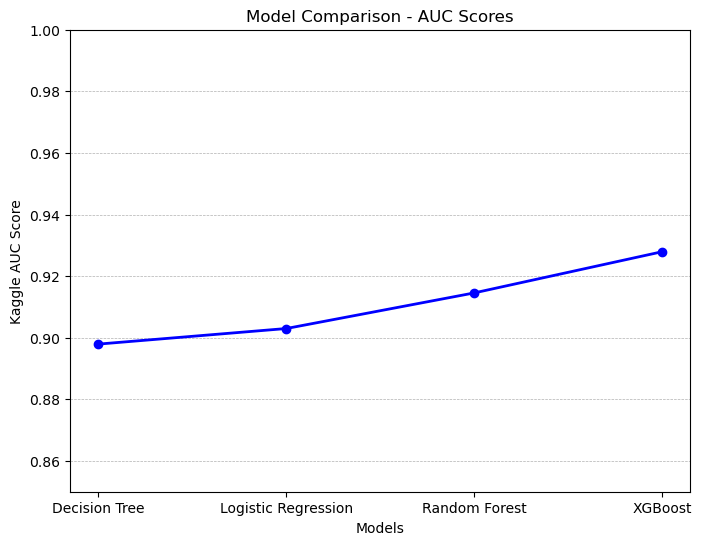

In [15]:
def plot_auc_scores(model_names, auc_scores):
    """
    Plots a line chart comparing AUC scores from Kaggle across models.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(model_names, auc_scores, marker='o', linestyle='-', color='blue', linewidth=2)
    plt.ylim(0.85, 1.0)
    plt.xlabel('Models')
    plt.ylabel('Kaggle AUC Score')
    plt.title('Model Comparison - AUC Scores')
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.savefig('ExperimentalResults/auc_scores_plot.png', dpi=300, bbox_inches='tight')  
    plt.show()
    
model_names = ["Decision Tree", "Logistic Regression", "Random Forest", "XGBoost"]
auc_scores = [0.89793, 0.90299, 0.91455, 0.92792]  # Scores from my Kaggle submissions
plot_auc_scores(model_names, auc_scores)

['family_status' 'education.num' 'occupation_Exec-managerial'
 'occupation_Other-service' 'capital.netgain' 'occupation_Prof-specialty'
 'occupation_Farming-fishing' 'age' 'sex_Female' 'hours.per.week'
 'occupation_Tech-support' 'occupation_Machine-op-inspct'
 'workclass_Self-emp-not-inc' 'occupation_Sales' 'age_group_Senior'
 'workclass_Federal-gov' 'workclass_Local-gov'
 'occupation_Handlers-cleaners' 'occupation_<NA>' 'race_Black'
 'occupation_Protective-serv' 'workclass_Self-emp-inc'
 'age_group_Middle-aged' 'race_White' 'workclass_State-gov'
 'workclass_<NA>' 'occupation_Adm-clerical' 'race_Asian-Pac-Islander'
 'native.country' 'occupation_Craft-repair' 'race_Amer-Indian-Eskimo'
 'occupation_Transport-moving' 'workclass_Private' 'education'
 'work_hours_category_Full-time' 'work_hours_category_Overtime'
 'occupation_Priv-house-serv' 'workclass_Without-pay' 'race_Other'
 'has_capital_gain_0' 'age_group_Young' 'workclass_Never-worked'
 'has_capital_gain_1' 'age_group_Elderly' 'work_

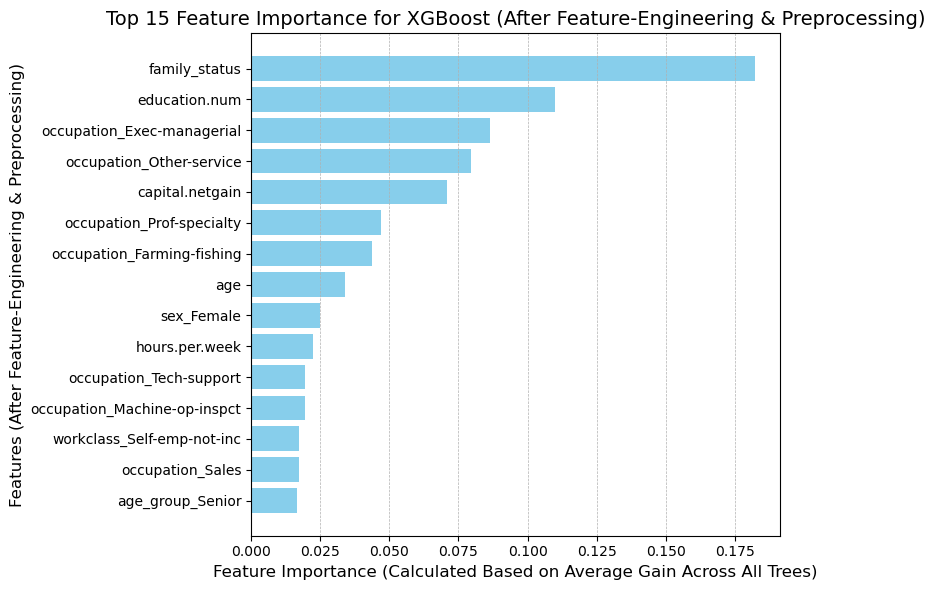

In [16]:
def plot_feature_importance(model, preprocessor, numerical_features, low_cardinality_cols, high_cardinality_cols):
    """
    Plots the feature importance for a given model.
    """
    # Extract feature names after preprocessing
    ohe_feature_names = preprocessor.named_transformers_['cat_low']['onehot'].get_feature_names_out(low_cardinality_cols)
    expanded_feature_names = numerical_features + list(ohe_feature_names) + high_cardinality_cols

    # Match feature importance to feature names
    importance = model.feature_importances_

    sorted_idx = np.argsort(importance)[::-1]  # Sort features by importance descending
    sorted_features = np.array(expanded_feature_names)[sorted_idx]
    sorted_importance = importance[sorted_idx]
    
    print(sorted_features)

    # Plot feature importance
    plt.figure(figsize=(8, 6))
    plt.barh(sorted_features[:15], sorted_importance[:15], color='skyblue')  # Plot top 15 features
    plt.xlabel('Feature Importance (Calculated Based on Average Gain Across All Trees)', fontsize=12)
    plt.ylabel('Features (After Feature-Engineering & Preprocessing)', fontsize=12)
    plt.title('Top 15 Feature Importance for XGBoost (After Feature-Engineering & Preprocessing)', fontsize=14)
    plt.gca().invert_yaxis()  # Highest importance at the top
    plt.grid(axis='x', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.savefig('ExperimentalResults/feature_importance_plot.png', dpi=300, bbox_inches='tight')  
    plt.show()

plot_feature_importance(best_xgb_model, preprocessor, numerical_features, low_cardinality_cols, high_cardinality_cols)

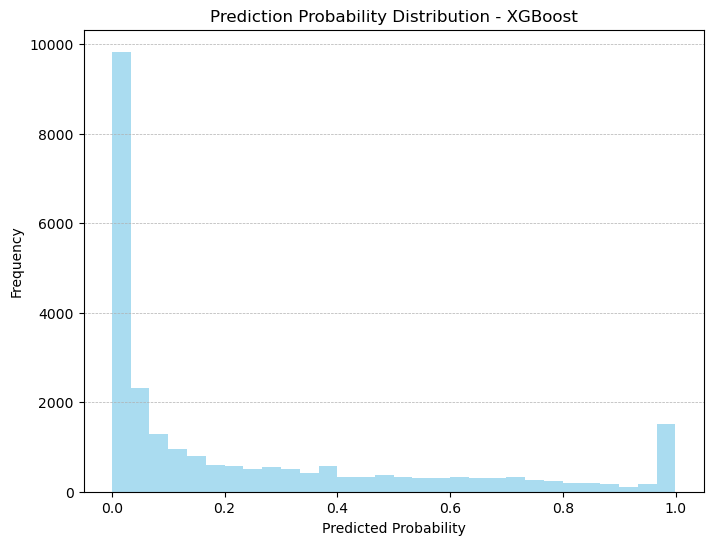

In [17]:
def plot_prediction_distribution(predictions, model_name):
    plt.figure(figsize=(8, 6))
    plt.hist(predictions, bins=30, color='skyblue', alpha=0.7)
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title(f'Prediction Probability Distribution - {model_name}')
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.savefig('ExperimentalResults/prediction_distribution_plot.png', dpi=300, bbox_inches='tight')  
    plt.show()

plot_prediction_distribution(y_train_pred_proba_xgb, 'XGBoost')

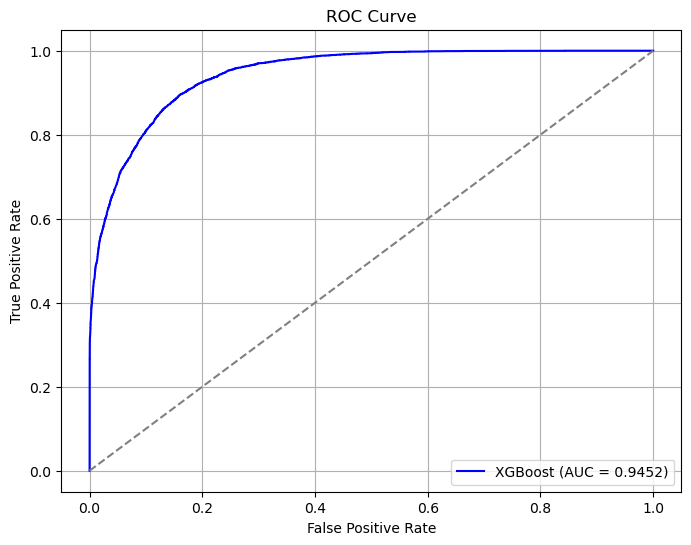

In [18]:
def plot_roc_curve(y_true, y_proba, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_score = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.4f})', color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.savefig('ExperimentalResults/roc_curve_plot.png', dpi=300, bbox_inches='tight')  
    plt.show()

plot_roc_curve(y_train, y_train_pred_proba_xgb, 'XGBoost')